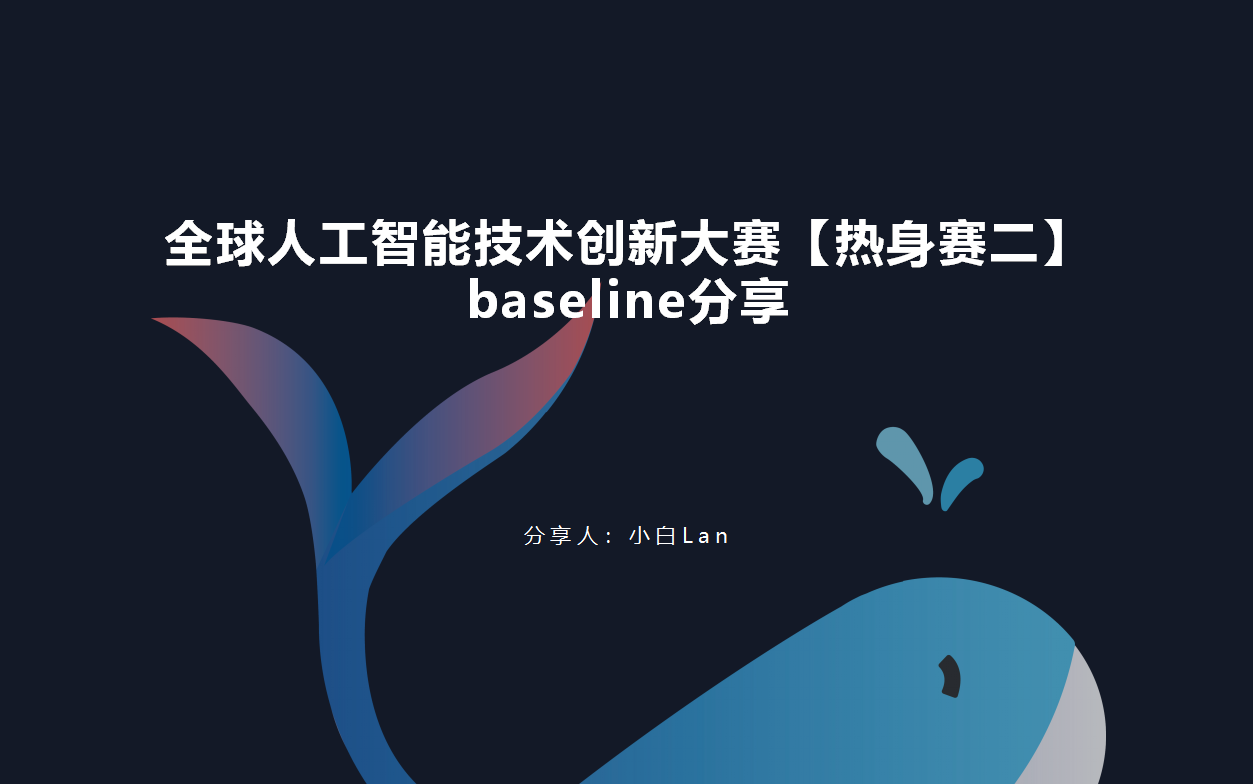

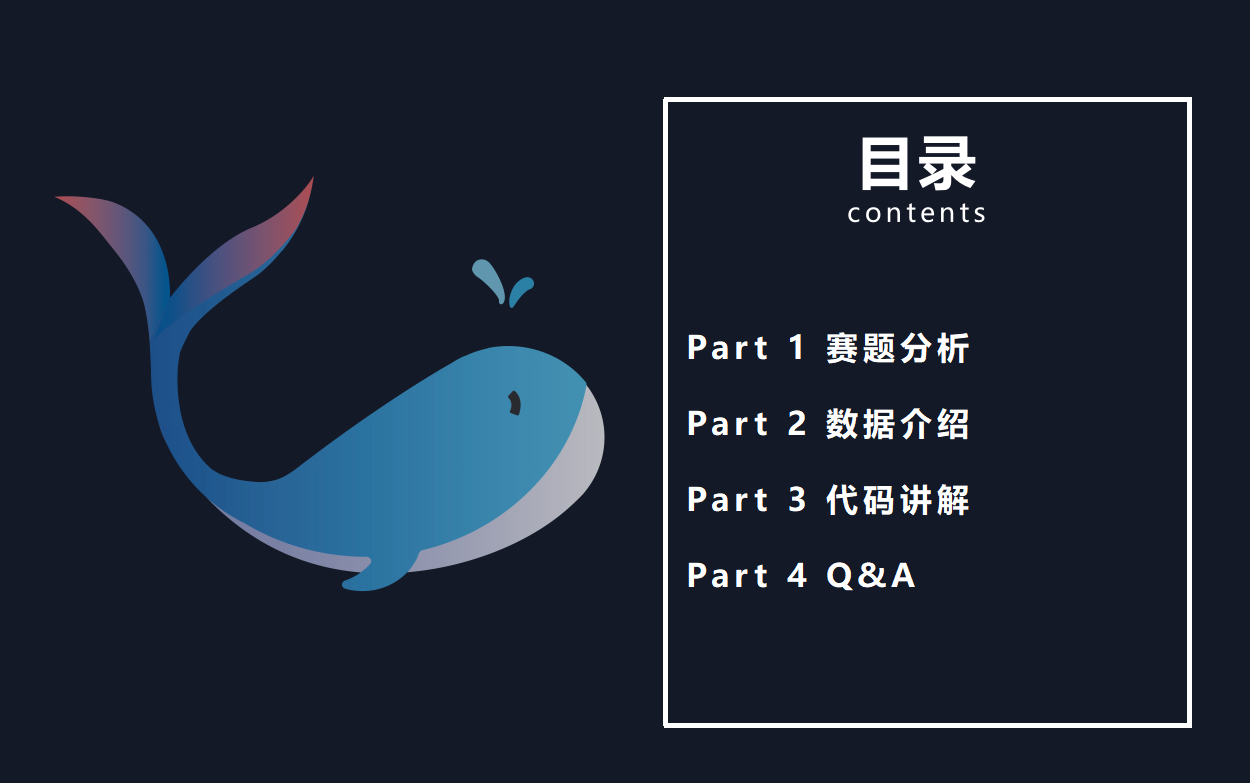

.

.


 * **赛题分析** 



    1.赛题为数据挖掘类型，通过预训练模型调优进行分类。

    2.是一个典型的多任务多分类问题。

    3.赛题禁止人工标注；微调阶段不得使用外部数据；三个任务只能共用一个bert；只能单折训练。
    
    4.评价指标为每个任务macro f1 值的均值。

    5.应用keras_bert实现bert调用并进行文本分类实践。

.

.





.

.
 * **数据介绍** 

    https://tianchi.aliyun.com/competition/entrance/531865/information
.

.

In [1]:
!nvidia-smi

Fri Feb 19 11:52:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
pip install keras-bert #keras tensorflow pycaret fasttext

In [3]:
import pandas as pd
import numpy as np
import os, sys
import codecs, gc
from sklearn.model_selection import KFold
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.metrics import top_k_categorical_accuracy
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [4]:
#路径配置
path = '..'
docker_data_path = '/tcdata/'

'''
路径说明：
|--tianchi-nlp
​	 |-- code
	|-- data
	|-- subs
  |-- chinese_roberta_wwm_large_ext_L-24_H-1024_A-16

其中：
/code 保存代码
/data #保存数据
/subs #保存数据
/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16 #bert路径
'''

########↘↘↘↘↘↘↘↘天池docker环境提交请注释以下代码↙↙↙↙↙↙↙↙########
'''如果在google colab上运行需要执行以下代码'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
nb_path = '/content/drive/My Drive/Colab Notebooks/'
sys.path.insert(0,nb_path)

path = "/content/drive/My Drive/天池nlp预训练/"
docker_data_path = path + '/data/'
########↖↖↖↖↖↖↖↖天池docker环境提交请注释以上代码↗↗↗↗↗↗↗↗########


#一些调优参数
er_patience = 2 #early_stopping patience
lr_patience = 5 #ReduceLROnPlateau patience
max_epochs = 3 #epochs
lr_rate = 3e-6 #learning rate
batch_sz = 4  #batch_size
maxlen = 256  #设置序列长度为，base模型要保证序列长度不超过512
lr_factor = 0.85 #ReduceLROnPlateau factor，lr*=factor
maxlentext1 = 200 #选择ocnli子句一的长度
n_folds = 10   #设置验证集的占比: 1/n_folds
#ReduceLROnPlateau其他参数：https://keras.io/zh/callbacks/#reducelronplateau

#path_bert = path + '/chinese_rbt6_L-6_H-768_A-12/'
path_bert = path + '/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/'

#预训练好的模型相关路径
config_path = path_bert + 'bert_config.json'
dict_path   = path_bert + 'vocab.txt'
checkpoint_path = path_bert + 'bert_model.ckpt'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7q1kep9_axD-P2f2CLy6NodmuenHAuDsLG3MdaYpVrERIAooMGeIc
Mounted at /content/drive


.

.

F12 打开，选择 console，输入一下代码防止页面session断掉

```
function ClickConnect(){
  colab.config
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End");
};
setInterval(ClickConnect, 300000)
```



如下图所示：

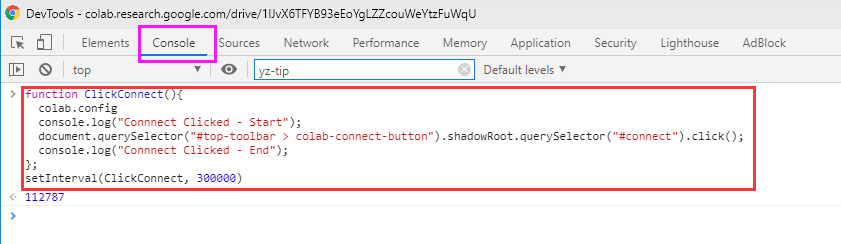

.

.


In [14]:
#数据读取

#将ocnli中content1[0:maxlentext1]+content2作为ocnli的content输入
times_train = pd.read_csv(path + '/data/TNEWS_train1128.csv',    sep='\t', header=None, names=('id', 'content', 'label')).astype(str)
ocemo_train = pd.read_csv(path + '/data/OCEMOTION_train1128.csv',sep='\t', header=None, names=('id', 'content', 'label')).astype(str)
ocnli_train = pd.read_csv(path + '/data/OCNLI_train1128.csv',    sep='\t', header=None, names=('id', 'content1', 'content2', 'label')).astype(str)
ocnli_train['content'] = ocnli_train['content1'] + ocnli_train['content2']#.apply( lambda x: x[:maxlentext1] )

times_testa = pd.read_csv(docker_data_path + 'tnews_test_B.csv',    sep='\t', header=None, names=('id', 'content')).astype(str)
ocemo_testa = pd.read_csv(docker_data_path + 'ocemotion_test_B.csv',sep='\t', header=None, names=('id', 'content')).astype(str)
ocnli_testa = pd.read_csv(docker_data_path + 'ocnli_test_B.csv',    sep='\t', header=None, names=('id', 'content1', 'content2')).astype(str)
ocnli_testa['content'] = ocnli_testa['content1']+ ocnli_testa['content2']#.apply( lambda x: x[:maxlentext1] ) 

In [15]:
#EDA分析
#子句文本长度统计分析
times_train['content'].str.len().describe(percentiles=[.99, .999, .9999]),ocemo_train['content'].str.len().describe(percentiles=[.99, .999, .9999])\
,ocnli_train['content1'].str.len().describe(percentiles=[.99, .999, .9999]),ocnli_train['content2'].str.len().describe(percentiles=[.99, .999, .9999])

(count     63360.000000
 mean         22.171086
 std           7.334206
 min           2.000000
 50%          22.000000
 99%          39.000000
 99.9%        48.000000
 99.99%       58.000000
 max         145.000000
 Name: content, dtype: float64, count     35315.000000
 mean         48.214328
 std          84.391942
 min           3.000000
 50%          34.000000
 99%         142.000000
 99.9%       172.000000
 99.99%     1040.953200
 max       12326.000000
 Name: content, dtype: float64, count     48778.000000
 mean         24.174607
 std          11.515428
 min           8.000000
 50%          22.000000
 99%          50.000000
 99.9%        50.000000
 99.99%       50.000000
 max          50.000000
 Name: content1, dtype: float64, count      48778.000000
 mean          15.828529
 std          977.396848
 min            2.000000
 50%           10.000000
 99%           27.000000
 99.9%         40.000000
 99.99%        54.000000
 max       215874.000000
 Name: content2, dtype: float64)

In [11]:
#构造输入、标签数据
#合并三个任务的训练、测试数据，将三任务转为单个任务
train_df = pd.concat([times_train, ocemo_train, ocnli_train[['id','content', 'label']]], axis=0).copy()
testa_df = pd.concat([times_testa, ocemo_testa, ocnli_testa[['id', 'content']]], axis=0).copy()

#LabelEncoder处理标签，因为label需要从0开始
encode_label = LabelEncoder()
train_df['label'] = encode_label.fit_transform(train_df['label'].apply(str))

###采用分层抽样的方式，从训练集中抽取10%作为验证集
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=222)

X_trn = pd.DataFrame()
X_val = pd.DataFrame()

for train_index, test_index in skf.split(train_df.copy(), train_df['label']):
  X_trn, X_val = train_df.iloc[train_index], train_df.iloc[test_index]
  break
###

subs = testa_df[['id']]
testa_df = testa_df[['content']]

#训练数据、测试数据和标签转化为模型输入格式
n_cls = len( train_df['label'].unique() )

#训练集每行的content、label转为tuple存入list，再转为numpy array
TRN_LIST = []
for data_row in X_trn.iloc[:].itertuples():
  TRN_LIST.append((data_row.content, to_categorical(data_row.label, n_cls)))
TRN_LIST = np.array(TRN_LIST)

#验证集每行的content、label转为tuple存入list，再转为numpy array
VAL_LIST = []
for data_row in X_val.iloc[:].itertuples():
  VAL_LIST.append((data_row.content, to_categorical(data_row.label, n_cls)))
VAL_LIST = np.array(VAL_LIST)

#测试集每行的content、label转为tuple存入list，再转为numpy array，其中label全为0
DATA_LIST_TEST = []
for data_row in testa_df.iloc[:].itertuples():
  DATA_LIST_TEST.append((data_row.content, to_categorical(0, n_cls)))
DATA_LIST_TEST = np.array(DATA_LIST_TEST)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [12]:
#EDA分析
#标签占比统计分析
train_df['label'].value_counts() / train_df.shape[0]

1     0.113467
0     0.109940
17    0.107397
23    0.084603
21    0.060318
10    0.047771
6     0.041749
4     0.039918
13    0.039036
8     0.033292
3     0.032668
5     0.032268
11    0.029487
19    0.029481
9     0.027690
18    0.027588
12    0.027541
16    0.027460
22    0.027412
15    0.022923
7     0.016853
2     0.008993
24    0.006097
20    0.004001
14    0.002048
Name: label, dtype: float64

In [9]:
#数据预处理
#让每条文本的长度相同，用0填充
def seq_padding(X, padding=0):
  L = [len(x) for x in X]
  ML = max(L)
  return np.array([  np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X  ])

#将词表中的词编号转换为字典
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
  for line in reader:
    token = line.strip()
    token_dict[token] = len(token_dict)

#重写tokenizer        
class OurTokenizer(Tokenizer):
  def _tokenize(self, text):
    R = []
    for c in text:
      if c in self._token_dict:
        R.append(c)
      elif self._is_space(c):
        R.append('[unused1]') # 用[unused1]来表示空格类字符
      else:
        R.append('[UNK]')     # 不在列表的字符用[UNK]表示
    return R

tokenizer = OurTokenizer(token_dict)

In [16]:
#data_generator只是一种为了节约内存的数据方式
class data_generator:
  global batch_sz
  def __init__(self, data, batch_size=batch_sz, shuffle=True):#此处修改batch_size
    self.data = data
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.steps = len(self.data) // self.batch_size
    if len(self.data) % self.batch_size != 0:
      self.steps += 1

  def __len__(self):
    return self.steps

  def __iter__(self):
    while True:
      idxs = list(range(len(self.data)))
      if self.shuffle:
        np.random.shuffle(idxs)
      X1, X2, Y = [], [], []
      for i in idxs:
        d = self.data[i]
        text = d[0][: maxlen]
        #text2 = d[0][maxlentext1:maxlen]
        x1, x2 = tokenizer.encode(first=text)#1, second=text2)#修改成输入两个子句

        y = d[1]
        X1.append(x1)
        X2.append(x2)
        Y.append([y])
        if len(X1) == self.batch_size or i == idxs[-1]:
          X1 = seq_padding(X1)
          X2 = seq_padding(X2)
          Y = seq_padding(Y)
          yield [X1, X2], Y[:, 0, :]
          [X1, X2, Y] = [], [], []

In [11]:
'''
def boolMap(arr):
  if arr > 0.5:
      return 1
  else:
      return 0

#自定义计算每个epoch的F1，注意不是batch的F1
class Metrics(Callback):
  def __init__(self, filepath):
    self.file_path = filepath

  def on_train_begin(self, logs=None):
    self.val_f1s = []
    self.best_val_f1 = 0
    self.val_recalls = []
    self.val_precisions = []

  def on_epoch_end(self, epoch, logs=None):
    val_predict = list(map(boolMap, self.model.predict([self.validation_data[0], self.validation_data[1]])))
    val_targ = self.validation_data[2]
    _val_f1 = f1_score(val_targ, val_predict)
    _val_recall = recall_score(val_targ, val_predict)
    _val_precision = precision_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print(_val_f1, _val_precision, _val_recall)
    print("max f1")
    print(max(self.val_f1s))
    if _val_f1 > self.best_val_f1:
      self.model.save_weights(self.file_path, overwrite=True)
      self.best_val_f1 = _val_f1
      print("best f1: {}".format(self.best_val_f1))
    else:
      print("val f1: {}, but not the best f1".format(_val_f1))
    return

f1metrics = Metrics(path)
'''
#定义计算每个batch的f1
from keras import backend as K

def f1(y_true, y_pred):
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
#bert模型搭建与配置
def build_bert(nclass):
  global lr_rate
  bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  #加载预训练模型

  for l in bert_model.layers:
    l.trainable = True

  x1_in = Input(shape=(None,))
  x2_in = Input(shape=(None,))

  x = bert_model([x1_in, x2_in])
  x = Lambda(lambda x: x[:, 0])(x) #取出[CLS]对应的向量用来做分类
  p = Dense(nclass, activation='softmax')(x) #接dense层softmax输出

  model = Model([x1_in, x2_in], p)
  model.compile(loss='categorical_crossentropy',#损失函数
                optimizer=Adam(lr_rate),    #优化器选择及学习率
                metrics=['accuracy', f1])   #评价函数

  print(model.summary())
  return model

In [ ]:
#交叉验证训练和测试模型
def run_nocv(nfold, trn_data, val_data, data_labels, data_test, n_cls):
  global er_patience
  global lr_patience
  global max_epochs
  global f1metrics
  global lr_factor
  test_model_pred = np.zeros((len(data_test), n_cls))

  model = build_bert(n_cls)
  #下行代码用于加载保存的权重继续训练
  #model.load_weights(path + '/subs/model.epoch02_val_loss1.0146_val_acc0.6479_val_f10.6359.hdf5')
  
  early_stopping = EarlyStopping(monitor= "val_f1", patience=er_patience) #早停法，防止过拟合 #'val_accuracy'
  plateau = ReduceLROnPlateau(monitor="val_f1", verbose=1, mode='max', factor=lr_factor, patience=lr_patience) #当评价指标不在提升时，减少学习率 #"val_accuracy"
  checkpoint = ModelCheckpoint(path + "/subs/model.epoch{epoch:02d}_val_loss{val_loss:.4f}_val_acc{val_accuracy:.4f}_val_f1{val_f1:.4f}.hdf5", monitor="val_f1", verbose=2, save_best_only=True, mode='max', save_weights_only=True) #保存val_f1最好的模型权重#'val_acc'

  #训练跟验证集可shuffle打乱，测试集不可打乱也无必要（不然在生成线上结果时没法跟ID对应上）
  #其他
  train_D = data_generator(trn_data, shuffle=True)
  valid_D = data_generator(val_data, shuffle=True)
  test_D = data_generator(data_test, shuffle=False)
  
  #模型训练
  model.fit_generator(
      train_D.__iter__(),
      steps_per_epoch=len(train_D),
      epochs=max_epochs,
      validation_data=valid_D.__iter__(),
      validation_steps=len(valid_D),
      callbacks=[early_stopping, plateau, checkpoint],
  )
  #模型预测
  test_model_pred = model.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)
  train_model_pred = test_model_pred#model.predict(train_D.__iter__(), steps=len(train_D), verbose=1)
 
  del model
  gc.collect()   #清理内存
  K.clear_session() #clear_session就是清除一个session

  return test_model_pred, train_model_pred

In [ ]:
#'''
#此cell代码为训练代码
cvs = 1
#输出为numpy array格式的25列概率
test_model_pred, train_model_pred = run_nocv(cvs, TRN_LIST, VAL_LIST, None, DATA_LIST_TEST, n_cls)

#将结果转为DataFrame格式
preds_tst_df = pd.DataFrame(test_model_pred)
preds_trn_df = pd.DataFrame(train_model_pred)

#再将range(0,25)做encode_label逆变换作为该DataFrame的列名
preds_col_names = encode_label.inverse_transform( range(0,n_cls) )
preds_tst_df.columns = preds_col_names
preds_trn_df.columns = preds_col_names

#保存输出概率，将该输出概率输入树模型还能提升分数，大概4个千分点
#preds_tst_df.to_csv(path + "/subs/tstsprob.csv", index=None)
#preds_trn_df.to_csv(path + "/subs/trnsprob.csv", index=None)
#'''

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, None, 1024)   324472832   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           model_1[0][0]              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


33177/33177 [==============================] - 7913s 237ms/step - loss: 0.5740 - accuracy: 0.7933 - f1: 0.7846 - val_loss: 1.1377 - val_accuracy: 0.6419 - val_f1: 0.6384

Epoch 00001: val_f1 improved from -inf to 0.63842, saving model to /content/drive/My Drive/天池nlp预训练//subs/model.epoch01_val_loss1.1377_val_acc0.6419_val_f10.6384.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1125/1125 [==============================] - 62s 49ms/step


In [ ]:
'''
#此cell代码为加载模型权重直接预测
#用于复现跟赛题第二阶段
model_name = "/subs/model.epoch01_val_loss1.1377_val_acc0.6419_val_f10.6384.hdf5"#模型权重路径跟名称
test_prob_name = "/subs/prob_.csv"

#rebuild model as model2
#simulating starting a new script
model2 = build_bert(25)

#load weights
model2.load_weights(path + model_name)

test_D  = data_generator(DATA_LIST_TEST, shuffle=False)
test_model_pred = model2.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)

preds_tst_df = pd.DataFrame(test_model_pred)

preds_col_names = encode_label.inverse_transform( range(0,n_cls) )
preds_tst_df.columns = preds_col_names

preds_tst_df.to_csv(path + test_prob_name, index=None)
'''

In [ ]:
#times_testa, ocemo_testa, ocnli_testa
#每行，从每个任务对应的标签列中找出最大的概率对应的列名作为预测结果
#如ocnli任务的预测结果只能为0、1、2，那么从preds_tst_df中选择0-1-2三列中每行概率最大的列名作为ocnli任务的测试集预测结果
#如ocemotion任务的预测结果只能为sadness、like、fear等7类，那么从preds_tst_df中选择sadness、like、fear等7列中每行概率最大的列名作为ocnli任务的测试集预测结果

times_preds = preds_tst_df.head(times_testa.shape[0])[times_train['label'].unique().tolist()]
times_preds = times_preds.eq(times_preds.max(1), axis=0).dot(times_preds.columns)

ocemo_preds = preds_tst_df.head(times_testa.shape[0] + ocemo_testa.shape[0]).tail(ocemo_testa.shape[0])[ocemo_train['label'].unique().tolist()]
ocemo_preds = ocemo_preds.eq(ocemo_preds.max(1), axis=0).dot(ocemo_preds.columns)

ocnli_preds = preds_tst_df.tail(ocnli_testa.shape[0])[ocnli_train['label'].unique().tolist()]
ocnli_preds = ocnli_preds.eq(ocnli_preds.max(1), axis=0).dot(ocnli_preds.columns)

times_sub = times_testa[['id']].copy()
times_sub['label'] = times_preds.values
times_sub.to_json(path + "/subs/tnews_predict_6342.json", orient='records', lines=True)

ocemo_sub = ocemo_testa[['id']].copy()
ocemo_sub['label'] = ocemo_preds.values
ocemo_sub.to_json(path + "/subs/ocemotion_predict_6342.json", orient='records', lines=True)

ocnli_sub = ocnli_testa[['id']].copy()
ocnli_sub['label'] = ocnli_preds.values
ocnli_sub.to_json(path + "/subs/ocnli_predict_6342.json", orient='records', lines=True)

In [ ]:
print(times_testa.shape, ocemo_testa.shape, ocnli_testa.shape)

  
   **线上分数**

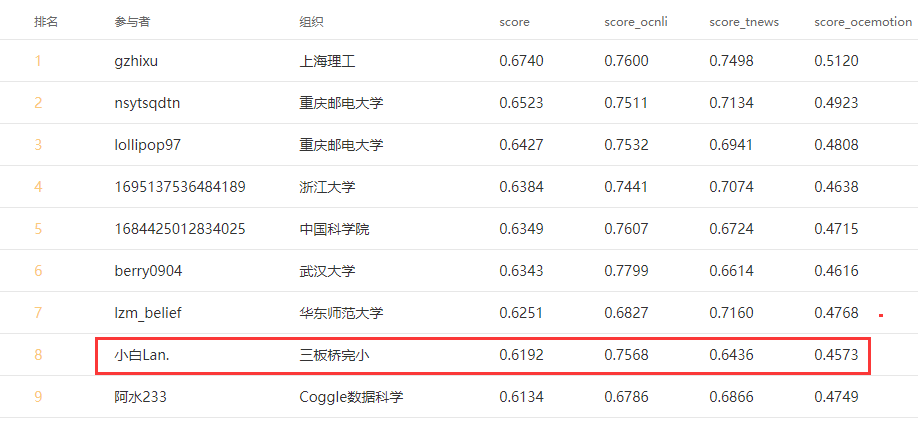

# baseline改进思路
    1.将bert的输出输入树模型

    2.模型输入两个子句

    3.共享bert参数，不同任务使用不同输出层

    4.进一步优化参数

    5.每个batch_size包含各个类别？ 自定义loss计算？